In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%writefile requirements.txt

-i https://artifactory.globoi.com/artifactory/api/pypi/pypi-all/simple
    
gflow[gcp]==1.1.0
scikit-learn==0.23.2
graphviz

Overwriting requirements.txt


In [3]:
pip install -r requirements.txt 

Looking in indexes: https://artifactory.globoi.com/artifactory/api/pypi/pypi-all/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 10.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
# This will be our repository
!mkdir .gflow

from gflow.orchestrator import LocalOrchestrator

orchestrator = LocalOrchestrator(repository_uri=".gflow")

mkdir: .gflow: File exists


2023-09-11 16:00:49 vitorpatalano.local root[82119] WARNING 
A new version of gflow is available.

Enter the following command to upgrade:
$ pip install 'gflow==1.17.0' --index-url https://artifactory.globoi.com/artifactory/api/pypi/pypi-all/simple



In [5]:
context = orchestrator.context()

In [10]:
## Loading the dataset as a pandas DataFrame

import pandas as pd
from sklearn import datasets

df_shots = pd.read_csv('Finalizacoes.csv')
del df_shots['Unnamed: 0']
df_shots.index.name = 'index'
df_shots['label'] = df_shots['Goal']
df_shots.head(3)


,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,coordenadas,x,y,X,Y,Center_dist,Distance,Angle Radians,Angle Degrees,label
index,,,,,,,,,,,,,,,,,,,,,
0,24,Finalização,Fora da Área Para Fora,PT36M57S,27,2,2023-05-04T01:04:37,69034,Paulinho,MEC,...,"(206, 582)",47.818182,19.750,32.516364,84.26250,2.181818,20.790505,0.347694,19.921417,0
1,20,Finalização,Dentro Área Fora,PT50M20S,34,2,2023-04-19T23:27:35,69034,Paulinho,MEC,...,"(299, 715)",54.545455,8.000,37.090909,96.60000,4.545455,8.950627,0.744626,42.663936,0
2,18,Finalização Cabeça,Grande Área Para Fora,PT2M49S,33,1,2023-04-05T23:03:24,117771,Damián Pizarro,ATA,...,"(206, 715)",41.454545,2.125,28.189091,102.76875,8.545455,6.224560,0.572359,32.793748,0


In [11]:
## Save the dataset in the repository

context.save_dataset('shots.csv', df_shots)
## Load the dataset to check if everything went fine
context.load_dataset('shots.csv').head(3)

,index,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,...,coordenadas,x,y,X,Y,Center_dist,Distance,Angle Radians,Angle Degrees,label
0,0,24,Finalização,Fora da Área Para Fora,PT36M57S,27,2,2023-05-04T01:04:37,69034,Paulinho,...,"(206, 582)",47.818182,19.750,32.516364,84.26250,2.181818,20.790505,0.347694,19.921417,0
1,1,20,Finalização,Dentro Área Fora,PT50M20S,34,2,2023-04-19T23:27:35,69034,Paulinho,...,"(299, 715)",54.545455,8.000,37.090909,96.60000,4.545455,8.950627,0.744626,42.663936,0
2,2,18,Finalização Cabeça,Grande Área Para Fora,PT2M49S,33,1,2023-04-05T23:03:24,117771,Damián Pizarro,...,"(206, 715)",41.454545,2.125,28.189091,102.76875,8.545455,6.224560,0.572359,32.793748,0


In [23]:
%%writefile shots_dataset_step.py

from sklearn import datasets

from gflow.workflow import Step

class ShotsDatasetStep(Step):
    def run(self, context):

        import pandas as pd
        # Lets parametrize the name of the dataset
        dataset_name = context.get_input('dataset_name')
        
        df_shots = pd.read_csv('Finalizacoes.csv')
        del df_shots['Unnamed: 0']
        df_shots.index.name = 'index'
        df_shots['label'] = df_shots['Goal']

        df_shots = df_shots[['label','Distance','Angle Radians','header']].copy()
                
        # Lets log the number of rows of this dataset
        context.log_metric('shots_dataset_size', df_shots.shape[0])

        context.save_dataset(dataset_name, df_shots)

Overwriting shots_dataset_step.py


In [24]:
from shots_dataset_step import ShotsDatasetStep

context.run_step(ShotsDatasetStep('ShotsDatasetStep'), inputs={'dataset_name': 'shots_step.csv'})

## Loading the dataset...
context.load_dataset('shots_step.csv').head(3)

,index,label,Distance,Angle Radians,header
0,0,0,20.790505,0.347694,0
1,1,0,8.950627,0.744626,0
2,2,0,6.224560,0.572359,1


In [25]:
# You can see all the metrics generated until now...

context.list_metrics()

{'ShotsDatasetStep': {'shots_dataset_size': 7705}}

In [26]:
# Load the dataset we saved in our context and get the features and labels...
df = context.load_dataset('shots_step.csv').set_index('index')

X = df.drop(columns=['label']).values.tolist()
y = df['label']

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('clf', LogisticRegression(random_state=0, max_iter=150))])

# Train!
pipeline.fit(X, y)

Pipeline(steps=[('clf', LogisticRegression(max_iter=150, random_state=0))])

In [28]:
# Save and version our model with a random version (you could also version it with a specific version)
import uuid

version = str(uuid.uuid4())

context.save_model('model', pipeline)
context.version_model('model', version)

version

'0b54dfe4-831a-41bf-bbdf-5e550a212c50'

In [29]:
# We can also tag model which is useful to know which was the last trained model or which one is in production

context.tag_model('model', version, 'dev')

In [30]:
# We can load our model by tag our version
model = context.load_model_by_tag('model', 'dev')
model = context.load_model_by_version('model', version)

In [31]:
%%writefile train_step.py

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from gflow.workflow import Step

class TrainStep(Step):
    def run(self, context):
        # Lets parametrize the name of the dataset and the max_iter parameter
        dataset_name = context.get_input('dataset_name')
        max_iter = context.get_input('max_iter') or 150
        
        # Load the dataset and the sklearn pipeline
        df = context.load_dataset(dataset_name).set_index('index')

        X = df.drop(columns=['label']).values.tolist()
        y = df['label']
        
        pipeline = Pipeline([('clf', LogisticRegression(random_state=0, max_iter=max_iter))])

        # Train!
        pipeline.fit(X, y)
        context.save_model('model', pipeline)
        
        #Version and tag the model
        model_version = context.get_input('model_version')
        model_tag = context.get_input('model_tag')

        if model_version:
            context.version_model('model', model_version)

        if model_version and model_tag:
            context.tag_model('model', model_version, model_tag)

Overwriting train_step.py


In [32]:
 # Running the train step
from train_step import TrainStep

context.run_step(TrainStep('TrainStep'), inputs={
    'dataset_name': 'shots_step.csv', 
    'model_version': str(uuid.uuid4()),
    'model_tag': 'train_step',
    'max_iter': 221})

## Loading the model...
context.load_model_by_tag('model', 'train_step')

Pipeline(steps=[('clf', LogisticRegression(max_iter=221, random_state=0))])

In [33]:
 %%writefile workflow.yaml

name: LinearRegression
team_name: mlplat
runtime:
    repository_uri: .gflow
inputs:
    - max_iter
    - model_version
    - model_tag
steps:
    - name: GetShotsDatasetStep
      runtime:
        class: shots_dataset_step.ShotsDatasetStep
      inputs:
        dataset_name: shots.csv
    - name: TrainStep
      runtime:
        class: train_step.TrainStep
      dependencies:
        - GetShotsDatasetStep
      inputs:
        dataset_name: shots.csv
        model_version: "{{workflow.model_version}}"
        model_tag: "{{workflow.model_tag}}"
        max_iter: "{{workflow.max_iter}}"

Overwriting workflow.yaml


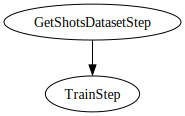

In [34]:
## You can load our yaml
from gflow.workflow import Workflow

workflow = Workflow("workflow.yaml")

# Draw our workflow
workflow.draw()

In [35]:
# And we can run our workflow!

version = str(uuid.uuid4())
summary = workflow.run(inputs={
    "model_version": version,
    "model_tag": "workflow-dev",
    "max_iter": 201
})

# You can save the execution_id of this run
execution_id = summary.execution_id

# Print all outputs
print(summary.outputs)

{'workflow.max_iter': 201, 'workflow.model_version': 'df9dda93-0555-4082-b0ea-867c9210244d', 'workflow.model_tag': 'workflow-dev'}


In [36]:
# Load the model

model = context.load_model_by_tag("model", "workflow-dev")

model 

Pipeline(steps=[('clf', LogisticRegression(max_iter=201, random_state=0))])

In [37]:
# We can use the execution_id to view all the metrics of the execution

context.list_metrics(execution_id=execution_id)

{'GetShotsDatasetStep': {'shots_dataset_size': 7705}, 'TrainStep': {}}